In [1]:
#API KEY Initialization
import os
from dotenv import load_dotenv
load_dotenv()
groq_api_key = os.getenv("GROQ")
langsmith_api_key = os.getenv("LANGSMITH")

In [2]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_PROJECT"] = "LangGraph"

In [3]:
from langchain_groq import ChatGroq

llm = ChatGroq(groq_api_key=groq_api_key, model_name = "gemma2-9b-it")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000002170CFCF230>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000002170D03D6A0>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

## Start Building ChatBot using LangGraph

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [5]:
class State(TypedDict):
    '''
    Messages have the type "list", the "add_messages" function
    in the annotation defines how this state key should be updated.
    [In this case, it appends messages to the list, rather than overwriting them]
    '''
    messages:Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [6]:
graph_builder

In [7]:
def chatbot(state:State):
    return {"messages":llm.invoke(state['messages'])}

In [8]:
graph_builder.add_node("chatbot", chatbot)

In [9]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [10]:
graph=graph_builder.compile()

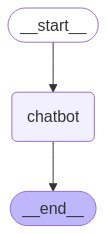

In [11]:
from IPython.display import display, Image

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [12]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit","q"]:
        print("Goodbye")
        break
    for event in graph.stream({'messages':("user", user_input)}):
        print(event.values())
        for value in event.values():
            print(value['messages'])
            print("Assistance: ", value['messages'].content)

KeyboardInterrupt: Interrupted by user

## Working with tools

In [36]:
!pip install arxiv wikipedia

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11754 sha256=321b9dc8946121778a10993b2636069ceaee97f389478d0d536bec02b8cfce2b
  Stored in directory: c:\users\aryan\appdata\local\pip\cache\wheels\79\1d\c8\b64e19423cc5a2a339450ea5d145e7c8eb3d4aa2b150cde33b
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0

In [13]:
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

#arxiv and wikipedia tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)